# Perfstat

## Import Data

In [14]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns
import re

sns.set(style="whitegrid", font_scale=1.5)

In [15]:
data = []

def normalise_name(row):
    n = row['name']
    if re.search("menhir",n) and re.search("sysver",n):
        row['name'] = "menhir.sysver"
    elif re.search("menhir",n) and re.search ("ocaml",n):
        row['name'] = "menhir.ocamly"
    elif re.search("menhir",n) and re.search ("sql-parser",n):
        row['name'] = "menhir.sql-parser"
    elif re.search("ydump",n) and re.search ("sample.json",n):
        row['name'] = "yojson_ydump.sample.json"
    elif re.search("cpdf",n) and re.search ("scale-to-fit",n):
        row['name'] = "cpdf.scale"
    elif re.search("cpdf",n) and re.search ("squeeze",n):
        row['name'] = "cpdf.squeeze"
    elif re.search("cpdf",n) and re.search ("blacktext",n):
        row['name'] = "cpdf.blacktext"
    elif re.search("minilight",n) and re.search ("roomfront",n):
        row['name'] = "minilight.roomfront"
    elif re.search("frama-c",n) and re.search ("slevel",n):
        row['name'] = "frama-c.slevel"
    elif re.search("alt-ergo",n) and re.search ("fill",n):
        row['name'] = "alt-ergo.fill.why"
    elif re.search("alt-ergo",n) and re.search ("yyll",n):
        row['name'] = "alt-ergo.yyll.why"
    elif re.search("cubicle",n) and re.search ("german",n):
        row['name'] = "cubicle.german_pfs.cub"
    elif re.search("cubicle",n) and re.search ("szymanski",n):
        row['name'] = "cubicle.szymanski_at.cub"
    elif re.search("main",n):
        row['name'] = "lexifi-g2pp."
        

def addrow(row, variant):
    if row:
        normalise_name(row)
        row['instructions_M'] = int (row['instructions'] / 1000000)
        del row['instructions']
        row['variant'] = variant
        data.append(row.copy())

def extract(field,row):
    m = re.search("\s*(.*)\s*"+field, l)
    if m:
        row[field] = int(m.group(1).replace(",","").replace(" ",""))


for file in glob.glob("*.perfstat.summary.bench"):
    row = {}
    with open(file) as f:
        variant = file.replace(".perfstat.summary.bench","")
        for l in f:
            # Benchmark
            m = re.search("Performance.*taskset --cpu-list 5 (.*)':",l)
            if m:
                addrow (row, variant) # add previous row
                row['name'] = m.group(1).replace("exe","").replace(" ","").replace("./","")
            # Instructions
            extract('instructions',row)
            # Instructions
            extract('context-switches',row)
        addrow(row, variant) # add last row
        
df = pd.DataFrame(data)
#pd.set_option('display.max_rows', df.shape[0]+1)
df

,name,context-switches,instructions_M,variant
0,levinson_durbin.,4,24482,5.1.0+trunk+decouple_gc_1
1,fannkuchredux2.12,27,590425,5.1.0+trunk+decouple_gc_1
2,regexredux2.,18,93752,5.1.0+trunk+decouple_gc_1
3,nqueens.14,5,31199,5.1.0+trunk+decouple_gc_1
4,sequence_cps.10000,4,14595,5.1.0+trunk+decouple_gc_1
...,...,...,...,...
95,evolutionary_algorithm.1000010000,47,254883,5.1.0+trunk_1
96,kb_no_exc.,4,14446,5.1.0+trunk_1
97,test_decompress.64524_288,6,27822,5.1.0+trunk_1
98,cubicle.szymanski_at.cub,418,2720834,5.1.0+trunk_1


In [16]:
df = df.loc[df['name'] != "soli.200"]

<hr>

### (USER INPUT)  Baseline variant name

Please choose the baseline variant name for normalized graphs:

In [17]:
baseline = '5.1.0+trunk_1'

Ensure that the baseline is one of the variants. Returns Raises `ValueError` if the baseline is not present in the loaded data:

In [18]:
is_present = df["variant"].unique().tolist().index(baseline)

## Helper code

In [19]:
# returns a dictionary with {key = name : value : metric}
# the metric corresponds to the variant
def create_column(df, variant, metric):
    df = pd.DataFrame.copy(df)
    variant_metric_name = list([ zip(df[metric], df[x], df['name']) 
              for x in df.columns.array if x == "variant" ][0])
    name_metric = {n:t for (t, v, n) in variant_metric_name if v == variant}
#     print(name_metric)
    return name_metric

def add_display_name(df,variant, metric):
    name_metric = create_column(pd.DataFrame.copy(df), variant, metric)
#    print(name_metric)
    disp_name = [name+" ("+str(round(name_metric[name], 2))+")" for name in df["name"]]
    df["display_name"] = pd.Series(disp_name, index=df.index)
    return df

def normalise(df,variant,topic,additionalTopics=[]):
    df = add_display_name(df,variant,topic)
    df = df.sort_values(["name","variant"])
    grouped = df.filter(items=['name',topic,'variant','display_name']+additionalTopics).groupby('variant')
    ndata_frames = []
    for group in grouped:
        (v,data) = group
        if(v != variant):
            data['b'+topic] = grouped.get_group(variant)[topic].values
            data[['n'+topic]] = data[[topic]].div(grouped.get_group(variant)[topic].values, axis=0)
            for t in additionalTopics:
#                 print(variant, t)
                data[[t]] = grouped.get_group(variant)[t].values
            ndata_frames.append(data)
    if ndata_frames:
        df = pd.concat(ndata_frames)
        return df
    else:
        print("need another variant to plot normalized graph")
        return pd.DataFrame()

def plot_normalised(df,variant,topic):
    df = pd.DataFrame.copy(df)
    df.sort_values(by=[topic],inplace=True)
    df[topic] = df[topic] - 1
    g = sns.catplot (x="display_name", y=topic, hue='variant', data = df, kind ='bar', aspect=4, bottom=1)
    g.set_xticklabels(rotation=90)
    g.ax.legend(loc=8)
    g._legend.remove()
    g.ax.set_xlabel("Benchmarks")
    return g
    # g.ax.set_yscale('log')

## Instructions

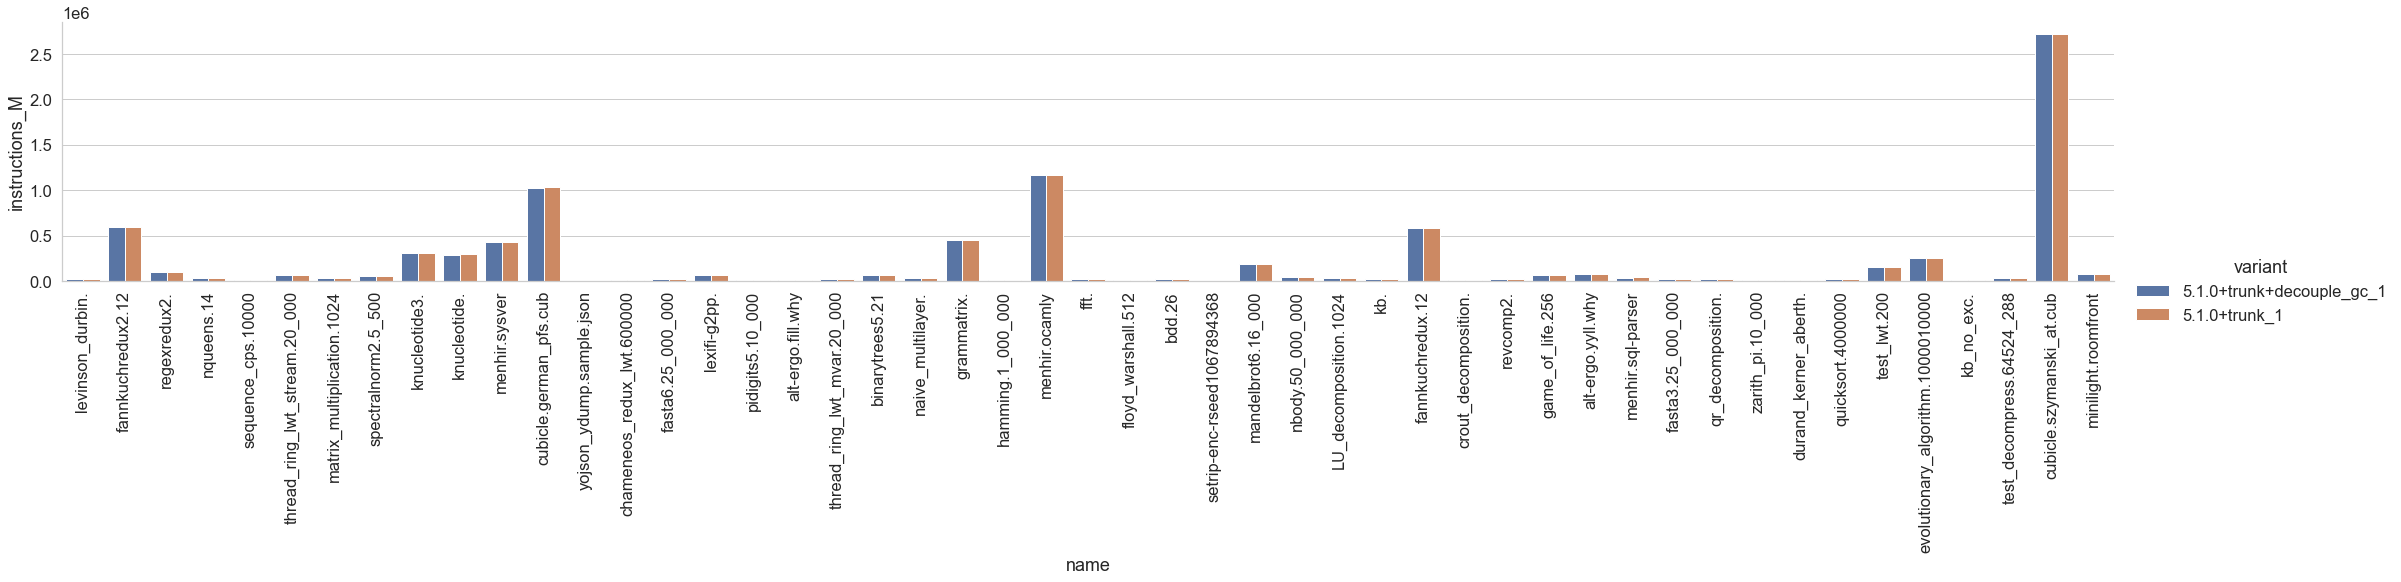

In [21]:
g = sns.catplot (x='name', y='instructions_M', hue='variant', data = df, kind ='bar', aspect=6)
g.set_xticklabels(rotation=90)

### Normalised

/var/folders/gb/k0glh4rj5rzf42qx6_n7ps9w0000gn/T/ipykernel_69822/2395037138.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["display_name"] = pd.Series(disp_name, index=df.index)


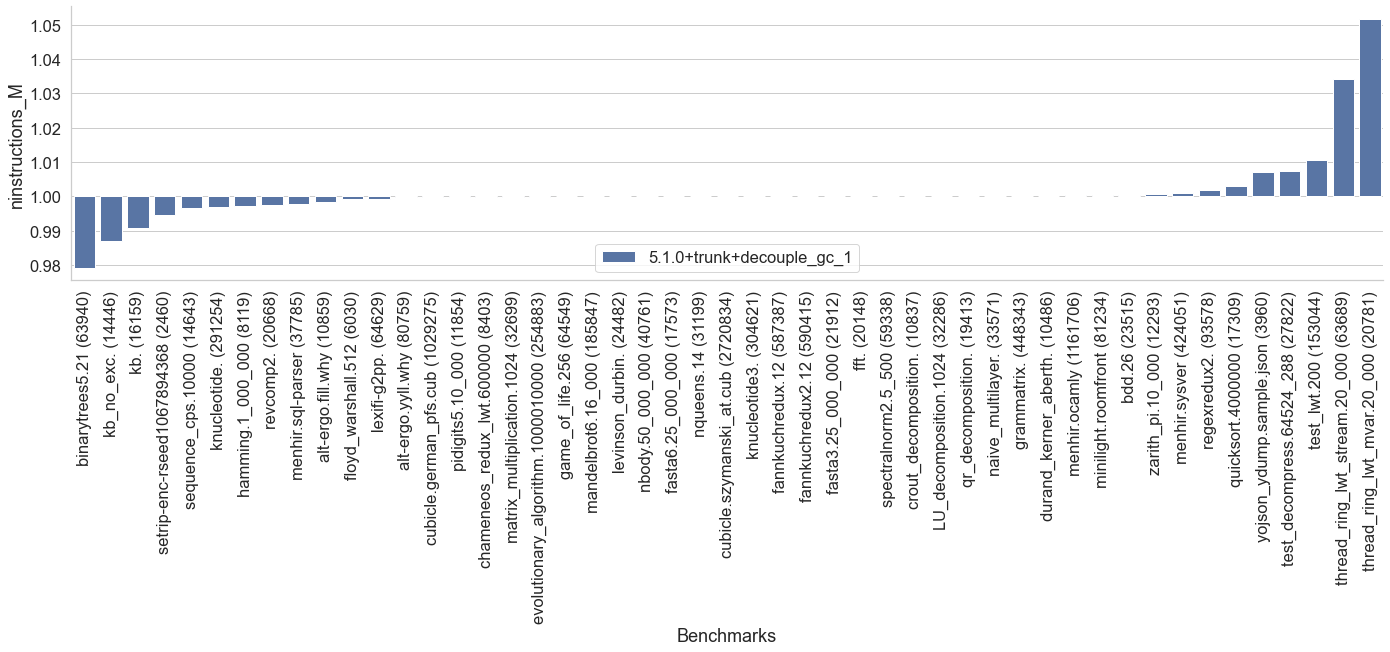

In [22]:
ndf = normalise(df,baseline,'instructions_M')
ax = plot_normalised(ndf,baseline,'ninstructions_M')